# A3: Predicting Car Price
### Aphisit Jaemyaem - st126130

In [30]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
import os 
import pickle ,tempfile
import shutil
import mlflow.pyfunc
from mlflow import register_model
from mlflow.tracking import MlflowClient
from pathlib import Path

### The data from A2 (preprocessed version)

In [31]:
df = pd.read_csv("../data/Cars.csv")

In [32]:
#cleansing data (from A1 predicting car price)
Owner_map = {"First Owner": 1,"Second Owner": 2,"Third Owner": 3,"Fourth & Above Owner": 4,"Test Drive Car": 5}
df['owner']=df['owner'].map(Owner_map)
df = df[(df['fuel'] != 'CNG') & (df['fuel'] != 'LPG')]
df['mileage']=df['mileage'].str.split().str[0].astype(float)
df['engine']=df['engine'].str.split().str[0].astype(float)
df['max_power']=df['max_power'].str.split().str[0].astype(float)
df['name']=df['name'].str.split().str[0]
df = df.rename(columns={'name':'brand'})
df=df.drop(columns =['torque'])
df = df[(df['owner'] != 5)]
df= pd.get_dummies(df, columns=['fuel','transmission','seller_type','owner'],drop_first=True)
X = df.drop(columns=['selling_price','engine','seats','brand']) 
y = df['selling_price']

In [33]:
#split train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


In [34]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape, y_test.shape)

Train shape: (5619, 11) (5619,)
Test  shape: (2409, 11) (2409,)


In [35]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [36]:
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_train['mileage'].fillna(X_train['mileage'].median(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].median(), inplace=True)

In [37]:
from sklearn.preprocessing import StandardScaler

num_features = ['year','km_driven','mileage','max_power']

scaler = StandardScaler()
X_train = X_train.copy() 
X_test  = X_test.copy()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

## Task 1  Classification

### 1.1 Convert the label selling price into discrete variable

In [38]:
#4-class classification
bins = pd.qcut(y_train, q=4, retbins=True, duplicates="drop")[1]
bins[0]  = -np.inf
bins[-1] =  np.inf
def class_label(y, bins):
    return pd.cut(y, bins=bins, labels=[0,1,2,3], include_lowest=True)

y_train_cls = class_label(y_train, bins)
y_test_cls  = class_label(y_test,  bins)
y_train_cls = y_train_cls.astype(int)
y_test_cls  = y_test_cls.astype(int)

In [39]:
print(y_train_cls)

6853    1
1495    1
7904    2
1281    0
1421    0
       ..
5293    1
5461    1
865     3
7701    3
7366    3
Name: selling_price, Length: 5619, dtype: int32


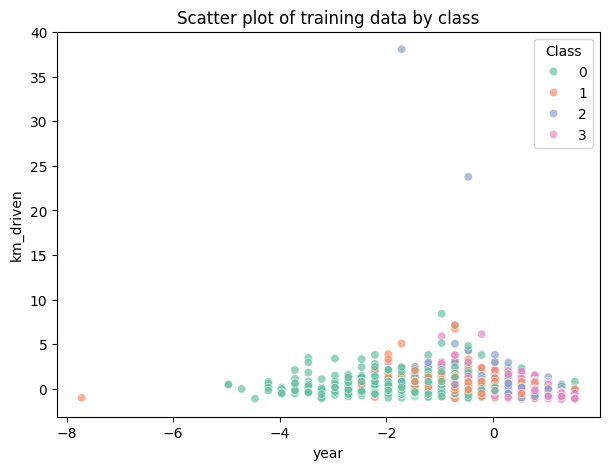

In [40]:
# some plot
x1 = X_train.iloc[:, 0]   # "year"
x2 = X_train.iloc[:, 1]   # "km_driven"

plt.figure(figsize=(7,5))
sns.scatterplot(x=x1, y=x2, hue=y_train_cls, palette="Set2", alpha=0.7)
plt.title("Scatter plot of training data by class")
plt.xlabel(X_train.columns[0])
plt.ylabel(X_train.columns[1])
plt.legend(title="Class")
plt.show()

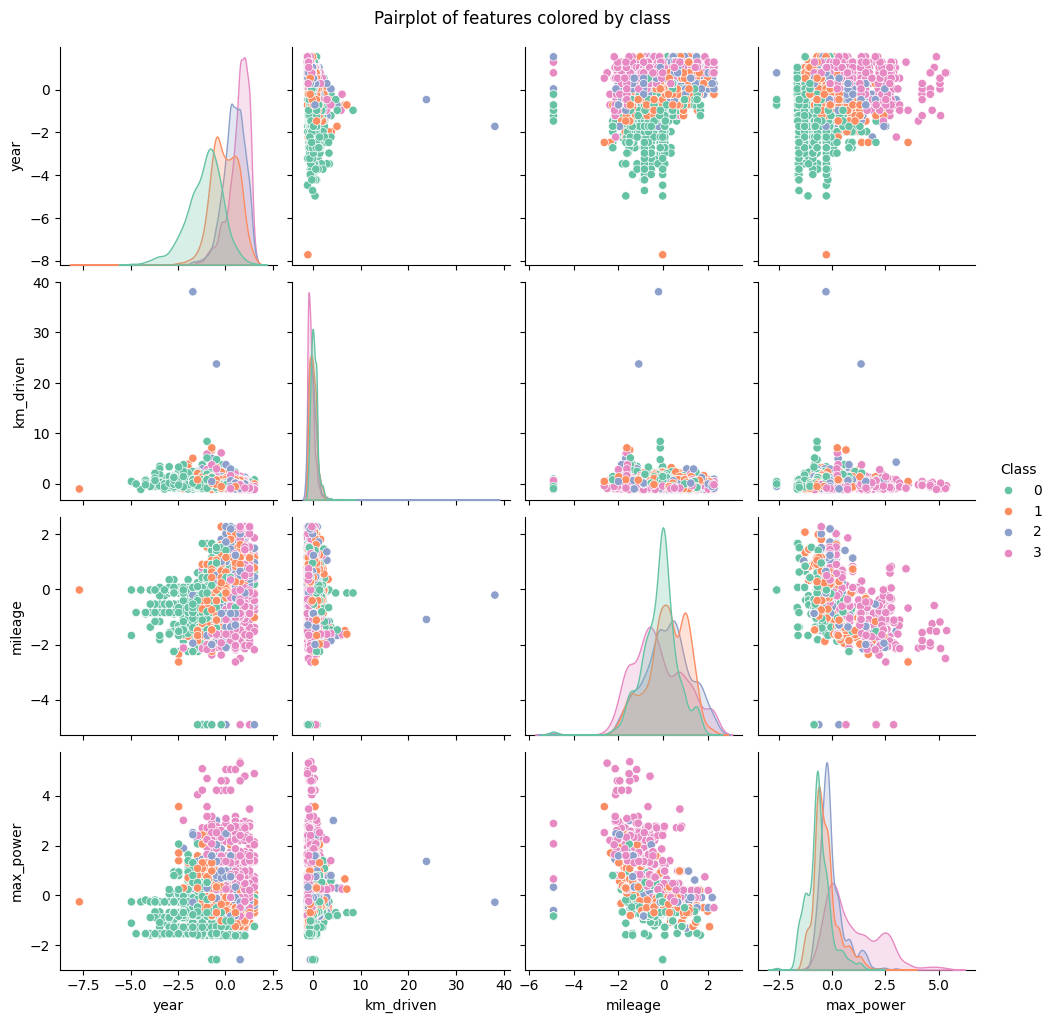

In [41]:
# Pairplot
df_plot = X_train.copy()
df_plot["Class"] = y_train_cls

cols_to_plot = ["year", "km_driven", "mileage", "max_power", "Class"]

sns.pairplot(df_plot[cols_to_plot], hue="Class", diag_kind="kde", palette="Set2")
plt.suptitle("Pairplot of features colored by class", y=1.02)
plt.show()


### 1.2 Algorithm

In [42]:
class LogisticRegression:

    def __init__(self, k, n, method, alpha=0.001, max_iter=5000, seed=42):
        self.k = k     
        self.n = n     
        self.alpha = alpha #learning rate
        self.max_iter = max_iter
        self.method = method
        self.rng = np.random.default_rng(seed)
    def _as_np(self, A):
        try:
            return np.asarray(A.to_numpy(), dtype=float)
        except AttributeError:
            return np.asarray(A, dtype=float)

    def _to_onehot(self,y, k):
        if y.ndim == 1:
            m = y.shape[0]
            Y = np.zeros((m, k), dtype=float)
            Y[np.arange(m), y.astype(int)] = 1.0
            return Y
        return y.astype(float)

    def _to_index(self,y):
        return np.argmax(y, axis=1) if y.ndim == 2 else y.astype(int)

    def _safe_div(self,a, b):
        return a / b if b != 0 else 0.0

    def fit(self, X, Y):
        X = self._as_np(X)
        Y = np.asarray(Y)    
        Y = self._to_onehot(Y, self.k)
        m = X.shape[0]
        self.W = self.rng.random((self.n, self.k)) * 0.01 
        self.losses = []

        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad
                if i % 500 == 0:
                    print(f"[batch] iter {i} loss={loss:.6f}")
            print(f"time taken: {time.time() - start_time:.3f}s")

        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = max(1, int(0.3 * m))
            for i in range(self.max_iter):
                idx = self.rng.choice(m, size=batch_size, replace=False)
                batch_X, batch_Y = X[idx], Y[idx]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad
                if i % 500 == 0:
                    print(f"[minibatch] iter {i} loss={loss:.6f}")
            print(f"time taken: {time.time() - start_time:.3f}s")

        elif self.method == "sto":
            start_time = time.time()
            order = self.rng.permutation(m)
            ptr = 0
            for i in range(self.max_iter):
                if ptr >= m:
                    order = self.rng.permutation(m)
                    ptr = 0
                idx = order[ptr]
                ptr += 1

                X_i = X[idx:idx+1]
                Y_i = Y[idx:idx+1]
                loss, grad = self.gradient(X_i, Y_i)
                self.losses.append(loss)
                self.W -= self.alpha * grad
                if i % 500 == 0:
                    print(f"[sto] iter {i} loss={loss:.6f}")
            print(f"time taken: {time.time() - start_time:.3f}s")

        else:
            raise ValueError('Method must be one of: "batch", "minibatch", "sto"')

        return self

    def softmax(self, Z):
        Zs = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(Zs)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def h_theta(self, X, W):
        return self.softmax(X @ W)

    def gradient(self, X, Y):
        X = self._as_np(X)
        m = X.shape[0]
        H = self.h_theta(X, self.W)                  
        eps = 1e-12
        loss = - np.sum(Y * np.log(H + eps)) / m
        error = H - Y                                 
        grad = (X.T @ error) / m                       
        return loss, grad

    def predict_proba(self, X):
        X = self._as_np(X)
        return self.h_theta(X, self.W)

    def predict(self, X_test):
        X_test = self._as_np(X_test)
        return np.argmax(self.h_theta(X_test, self.W), axis=1)

    # Metrics
    def accuracy(self, y_true, y_pred):
        y_true = self._to_index(y_true)
        y_pred = self._to_index(y_pred)
        return float(np.mean(y_true == y_pred))

    def _counts_for_class(self, y_true_idx, y_pred_idx, c):
        TP = int(np.sum((y_true_idx == c) & (y_pred_idx == c))) #True Positive
        FP = int(np.sum((y_true_idx != c) & (y_pred_idx == c))) #False Positive
        FN = int(np.sum((y_true_idx == c) & (y_pred_idx != c))) #False Negative
        TN = int(np.sum((y_true_idx != c) & (y_pred_idx != c))) #True Negative
        return TP, FP, FN, TN

    def _prf1_for_class(self, y_true_idx, y_pred_idx, c):
        TP, FP, FN, _ = self._counts_for_class(y_true_idx, y_pred_idx, c)
        p = self._safe_div(TP, TP + FP)
        r = self._safe_div(TP, TP + FN)
        f1 = self._safe_div(2 * p * r, (p + r)) if (p + r) > 0 else 0.0
        support = int(np.sum(y_true_idx == c))
        return p, r, f1, support

    def metrics_report(self, X, Y_true, report_format=False):
        X = self._as_np(X)
        y_true_idx = self._to_index(Y_true)
        y_pred_idx = self.predict(X)

        acc = self.accuracy(y_true_idx, y_pred_idx)

        per_class = {}
        precisions, recalls, f1s, supports = [], [], [], []

        for c in range(self.k):
            p, r, f1, sup = self._prf1_for_class(y_true_idx, y_pred_idx, c)
            per_class[str(c)] = {
                "precision": float(p),
                "recall": float(r),
                "f1": float(f1),
                "support": sup,
            }
            precisions.append(p)
            recalls.append(r)
            f1s.append(f1)
            supports.append(sup)

        supports = np.array(supports, dtype=float)
        total = supports.sum() if supports.sum() > 0 else 1.0

        macro = {
            "precision": float(np.mean(precisions)),
            "recall": float(np.mean(recalls)),
            "f1": float(np.mean(f1s)),
        }
        weighted = {
            "precision": float(np.sum(precisions * supports) / total),
            "recall": float(np.sum(recalls * supports) / total),
            "f1": float(np.sum(f1s * supports) / total),
        }

        report = {
            "accuracy": acc,
            "macro": macro,
            "weighted": weighted,
            "per_class": per_class,}

        if report_format:
            self.print_report(report)

        return report

    def print_report(self, report):
    
        print("---------------------Report------------------------")
        print(f"Accuracy: {report['accuracy']:.4f}\n")

        print("Per Class:")
        for cls, metrics in report["per_class"].items():
            print(f"- Class {cls} → "
                  f"Precision: {metrics['precision']:.4f} | "
                  f"Recall: {metrics['recall']:.4f} | "
                  f"F1: {metrics['f1']:.4f} | "
                  f"Support: {metrics['support']}")

        print("\nMacro Avg:")
        print(f"Precision: {report['macro']['precision']:.4f}")
        print(f"Recall:    {report['macro']['recall']:.4f}")
        print(f"F1:        {report['macro']['f1']:.4f}")

        print("\nWeighted Avg:")
        print(f"Precision: {report['weighted']['precision']:.4f}")
        print(f"Recall:    {report['weighted']['recall']:.4f}")
        print(f"F1:        {report['weighted']['f1']:.4f}")

    # Plot
    def plot(self):
        plt.plot(np.arange(len(self.losses)), self.losses, label="Train Loss")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.tight_layout()

### 1.3 Running the algorithm and compare with scikit-learn classification

In [43]:
model = LogisticRegression(k=4, n=X_train.shape[1], method="minibatch", alpha=0.01, max_iter=5000)
model.fit(X_train, y_train_cls.values)

report_model = model.metrics_report(X_test, y_test_cls.values, report_format=True)
print(report_model)

[minibatch] iter 0 loss=1.388294
[minibatch] iter 500 loss=0.977379
[minibatch] iter 1000 loss=0.915798
[minibatch] iter 1500 loss=0.885144
[minibatch] iter 2000 loss=0.833611
[minibatch] iter 2500 loss=0.825613
[minibatch] iter 3000 loss=0.807040
[minibatch] iter 3500 loss=0.795440
[minibatch] iter 4000 loss=0.804442
[minibatch] iter 4500 loss=0.778420
time taken: 1.030s
---------------------Report------------------------
Accuracy: 0.6708

Per Class:
- Class 0 → Precision: 0.7733 | Recall: 0.8515 | F1: 0.8105 | Support: 633
- Class 1 → Precision: 0.5808 | Recall: 0.5391 | F1: 0.5591 | Support: 627
- Class 2 → Precision: 0.5307 | Recall: 0.5241 | F1: 0.5274 | Support: 561
- Class 3 → Precision: 0.7726 | Recall: 0.7568 | F1: 0.7646 | Support: 588

Macro Avg:
Precision: 0.6643
Recall:    0.6679
F1:        0.6654

Weighted Avg:
Precision: 0.6665
Recall:    0.6708
F1:        0.6679
{'accuracy': 0.6708177667081777, 'macro': {'precision': 0.6643313956245097, 'recall': 0.6678606605571094, 'f1

In [44]:
#classification_report
y_pred_sklearn = model.predict(X_test)
print(classification_report(y_test_cls, y_pred_sklearn, digits=4))

              precision    recall  f1-score   support

           0     0.7733    0.8515    0.8105       633
           1     0.5808    0.5391    0.5591       627
           2     0.5307    0.5241    0.5274       561
           3     0.7726    0.7568    0.7646       588

    accuracy                         0.6708      2409
   macro avg     0.6643    0.6679    0.6654      2409
weighted avg     0.6665    0.6708    0.6679      2409



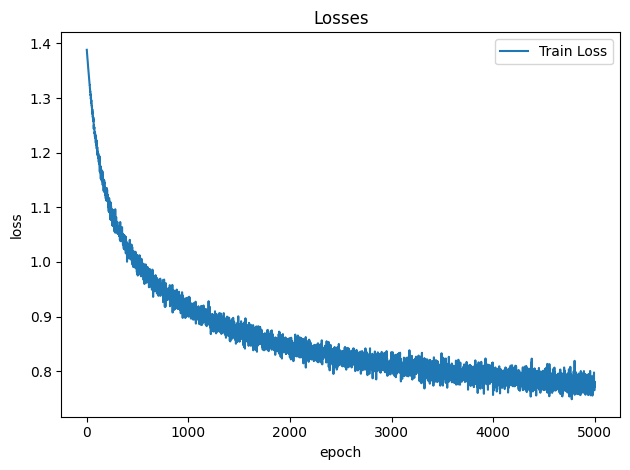

In [45]:
model.plot()

### 1.4 what does support in the classification report means?
- **support** = the number of true samples of each class in your evaluation dataset (y_true).

## Task 2 Ridge Logistic Regression

In [46]:
#Ridge penalty (L2)
class RidgePenalty:
    def __init__(self, l=0.01, exclude_bias=False):
        self.l = float(l)
        self.exclude_bias = bool(exclude_bias)

    def _mask(self, theta):
        if not self.exclude_bias:
            return theta
        t = theta.copy()
        t[0, :] = 0.0 
        return t

    def __call__(self, theta):
        T = self._mask(theta)
        return self.l * np.sum(np.square(T))

    def derivation(self, theta):
        T = self._mask(theta)
        return 2.0 * self.l * T

class RidgeLogisticRegression(LogisticRegression):
    def __init__(self, k, n, method, alpha=0.001, max_iter=5000, seed=42,
                 penalty: RidgePenalty | None = None):
        super().__init__(k, n, method, alpha=alpha, max_iter=max_iter, seed=seed)
        self.penalty = penalty

    def gradient(self, X, Y):
        X = self._as_np(X)
        m = X.shape[0]
        H = self.h_theta(X, self.W)          #softmax
        eps = 1e-12
        loss = - np.sum(Y * np.log(H + eps)) / m  #cross-entropy

        if self.penalty is not None:
            loss += self.penalty(self.W)

        error = H - Y
        grad = (X.T @ error) / m            

        if self.penalty is not None:
            grad += self.penalty.derivation(self.W)

        return loss, grad

## Task 3 Deployment 

### 3.1 Log experiment on the server and  Deploy the Model

In [55]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"

mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_experiment("st126130-a3") 

from mlflow.tracking import MlflowClient
client = MlflowClient()
_ = client.search_experiments()  
print("OK: authenticated & connected")

OK: authenticated & connected


### 3.2 Run experiment

In [ ]:
class LogisticRegressionWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        import os
        with open(os.path.join(context.artifacts["model_dir"], "model.pkl"), "rb") as f:
            self.model = pickle.load(f)

    def predict(self, context, model_input):
        import numpy as np
        X = model_input.values if hasattr(model_input, "values") else np.asarray(model_input)
        return self.model.predict(X)

def train_and_log_metrics_only(model, run_name, X_train, y_train, X_test, y_test,
                               feat_names=None, tags=None):
    os.makedirs("ml_artifacts", exist_ok=True)

    with mlflow.start_run(run_name=run_name) as run:
        # params/tags
        mlflow.log_param("method",   getattr(model, "method", "n/a"))
        mlflow.log_param("alpha",    getattr(model, "alpha", "n/a"))
        mlflow.log_param("max_iter", getattr(model, "max_iter", "n/a"))
        lam = getattr(getattr(model, "penalty", None), "l", None)
        if lam is not None:
            mlflow.log_param("lambda", lam)
        if tags:
            for k, v in tags.items():
                mlflow.set_tag(k, v)

        # train
        t0 = time.time()
        model.fit(X_train, y_train)
        mlflow.log_metric("train_time_sec", time.time() - t0)

        # evaluate
        rep_tr = model.metrics_report(X_train, y_train)
        rep_te = model.metrics_report(X_test,  y_test)
        mlflow.log_metric("train_acc",        rep_tr["accuracy"])
        mlflow.log_metric("test_acc",         rep_te["accuracy"])
        mlflow.log_metric("test_macro_f1",    rep_te["macro"]["f1"])
        mlflow.log_metric("test_weighted_f1", rep_te["weighted"]["f1"])

        model.plot()
        plt.savefig("ml_artifacts/loss_curve.png")
        mlflow.log_artifact("ml_artifacts/loss_curve.png")
        plt.close()

        lam_val = getattr(getattr(model, "penalty", None), "l", None)
        return {
            "run_id": run.info.run_id,
            "test_acc": rep_te["accuracy"],
            "cfg": {
                "method": getattr(model, "method", None),
                "alpha":  getattr(model, "alpha", None),
                "max_iter": getattr(model, "max_iter", None),
                "lambda": lam_val
            }
        }

methods   = ["batch", "minibatch", "sto"]
lambdas   = [None, 0.01, 0.1, 1.0]
alpha     = 0.01
max_iter  = 5000
k_classes = 4

feat_names = list(X_train.columns) if hasattr(X_train, "columns") else None

best = {"test_acc": -1, "run_id": None, "cfg": None, "desc": ""}

for method in methods:
    for lam in lambdas:
        if lam is None:
            model = LogisticRegression(
                k=k_classes, n=X_train.shape[1],
                method=method, alpha=alpha, max_iter=max_iter, seed=42
            )
            run_name = f"LogisticRegression_no_penalty__{method}"
            tags = {"regularization": "none"}
        else:
            ridge = RidgePenalty(l=lam)
            model = RidgeLogisticRegression(
                k=k_classes, n=X_train.shape[1],
                method=method, alpha=alpha, max_iter=max_iter, seed=42,
                penalty=ridge
            )
            run_name = f"RidgeLogisticRegression_l{lam}__{method}"
            tags = {"regularization": "ridge", "lambda": lam}

        res = train_and_log_metrics_only(
            model, run_name,
            X_train, y_train_cls.astype(int),
            X_test,  y_test_cls.astype(int),
            feat_names=feat_names, tags=tags
        )

        if res["test_acc"] > best["test_acc"] or best["run_id"] is None:
            best = {**res, "desc": run_name}

MODEL_NAME = "st126130-a3-model" 

if best["run_id"] is None:
    print("No runs were logged, cannot register a model.")
else:
    print(f"[BEST] run_id={best['run_id']}  desc={best['desc']}  test_acc={best['test_acc']:.4f}")

    cfg = best["cfg"]
    if cfg["lambda"] is None:
        final_model = LogisticRegression(
            k=k_classes, n=X_train.shape[1],
            method=cfg["method"], alpha=cfg["alpha"], max_iter=cfg["max_iter"], seed=42
        )
    else:
        final_model = RidgeLogisticRegression(
            k=k_classes, n=X_train.shape[1],
            method=cfg["method"], alpha=cfg["alpha"], max_iter=cfg["max_iter"], seed=42,
            penalty=RidgePenalty(l=cfg["lambda"])
        )

    final_model.fit(X_train, y_train_cls.astype(int))

    with mlflow.start_run(run_id=best["run_id"]):
        tmp_dir = "tmp_model"
        os.makedirs(tmp_dir, exist_ok=True)
        with open(os.path.join(tmp_dir, "model.pkl"), "wb") as f:
            pickle.dump(final_model, f)

        mlflow.pyfunc.log_model(
            artifact_path="model",               
            python_model=LogisticRegressionWrapper(),
            artifacts={"model_dir": tmp_dir},
        )
        shutil.rmtree(tmp_dir, ignore_errors=True)
            
    # Register & Promote
    best_model_uri = f"runs:/{best['run_id']}/model"
    result = register_model(model_uri=best_model_uri, name=MODEL_NAME)
    print(f"Registered {MODEL_NAME} version={result.version}")

    client = MlflowClient()
    client.transition_model_version_stage(
        name=MODEL_NAME, version=result.version, stage="Staging")
    print(f"Promoted {MODEL_NAME} v{result.version} -> Staging")


[batch] iter 0 loss=1.388176
[batch] iter 500 loss=0.997058
[batch] iter 1000 loss=0.915664
[batch] iter 1500 loss=0.873052
[batch] iter 2000 loss=0.845560
[batch] iter 2500 loss=0.825962
[batch] iter 3000 loss=0.811112
[batch] iter 3500 loss=0.799392
[batch] iter 4000 loss=0.789872
[batch] iter 4500 loss=0.781973
time taken: 1.987s


2025/10/04 19:10:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_no_penalty__batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/ae13b8fe8cb642b2bf978624fc0ce985.
2025/10/04 19:10:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[batch] iter 0 loss=1.388192
[batch] iter 500 loss=1.021447
[batch] iter 1000 loss=0.963662
[batch] iter 1500 loss=0.940737
[batch] iter 2000 loss=0.929576
[batch] iter 2500 loss=0.923597
[batch] iter 3000 loss=0.920201
[batch] iter 3500 loss=0.918195
[batch] iter 4000 loss=0.916977
[batch] iter 4500 loss=0.916221
time taken: 2.016s


2025/10/04 19:10:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.01__batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/5e448b1d64ed4587bc144a9b4ee96651.
2025/10/04 19:10:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[batch] iter 0 loss=1.388337
[batch] iter 500 loss=1.154259
[batch] iter 1000 loss=1.150754
[batch] iter 1500 loss=1.150621
[batch] iter 2000 loss=1.150614
[batch] iter 2500 loss=1.150614
[batch] iter 3000 loss=1.150614
[batch] iter 3500 loss=1.150614
[batch] iter 4000 loss=1.150614
[batch] iter 4500 loss=1.150614
time taken: 1.911s


2025/10/04 19:10:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.1__batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/68067a1409cd45a1beb718c265a20c50.
2025/10/04 19:10:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[batch] iter 0 loss=1.389789
[batch] iter 500 loss=1.333307
[batch] iter 1000 loss=1.333307
[batch] iter 1500 loss=1.333307
[batch] iter 2000 loss=1.333307
[batch] iter 2500 loss=1.333307
[batch] iter 3000 loss=1.333307
[batch] iter 3500 loss=1.333307
[batch] iter 4000 loss=1.333307
[batch] iter 4500 loss=1.333307
time taken: 1.920s


2025/10/04 19:10:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l1.0__batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/f4dd3e6fb3634ad486fbe8acae6b5af1.
2025/10/04 19:10:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[minibatch] iter 0 loss=1.388294
[minibatch] iter 500 loss=0.977379
[minibatch] iter 1000 loss=0.915798
[minibatch] iter 1500 loss=0.885144
[minibatch] iter 2000 loss=0.833611
[minibatch] iter 2500 loss=0.825613
[minibatch] iter 3000 loss=0.807040
[minibatch] iter 3500 loss=0.795440
[minibatch] iter 4000 loss=0.804442
[minibatch] iter 4500 loss=0.778420
time taken: 0.958s


2025/10/04 19:10:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_no_penalty__minibatch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/5a13c04612f4410ea33798b84dcbac7e.
2025/10/04 19:10:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[minibatch] iter 0 loss=1.388311
[minibatch] iter 500 loss=1.002082
[minibatch] iter 1000 loss=0.963652
[minibatch] iter 1500 loss=0.952256
[minibatch] iter 2000 loss=0.918703
[minibatch] iter 2500 loss=0.923859
[minibatch] iter 3000 loss=0.916730
[minibatch] iter 3500 loss=0.914805
[minibatch] iter 4000 loss=0.929536
[minibatch] iter 4500 loss=0.913741
time taken: 0.999s


2025/10/04 19:10:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.01__minibatch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/d129ae55cb2a4c4aa0c8a88935781ce4.
2025/10/04 19:10:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[minibatch] iter 0 loss=1.388456
[minibatch] iter 500 loss=1.137471
[minibatch] iter 1000 loss=1.149803
[minibatch] iter 1500 loss=1.159050
[minibatch] iter 2000 loss=1.144264
[minibatch] iter 2500 loss=1.152862
[minibatch] iter 3000 loss=1.149867
[minibatch] iter 3500 loss=1.147627
[minibatch] iter 4000 loss=1.158387
[minibatch] iter 4500 loss=1.149226
time taken: 0.979s


2025/10/04 19:10:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.1__minibatch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/b3c48b1c0b12403eb373060ea1815391.
2025/10/04 19:10:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[minibatch] iter 0 loss=1.389907
[minibatch] iter 500 loss=1.327215
[minibatch] iter 1000 loss=1.332215
[minibatch] iter 1500 loss=1.335827
[minibatch] iter 2000 loss=1.331784
[minibatch] iter 2500 loss=1.334663
[minibatch] iter 3000 loss=1.333821
[minibatch] iter 3500 loss=1.332258
[minibatch] iter 4000 loss=1.335837
[minibatch] iter 4500 loss=1.333415
time taken: 0.978s


2025/10/04 19:10:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l1.0__minibatch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/f260b6b11b9b466eb35e784b0a38e57f.
2025/10/04 19:10:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[sto] iter 0 loss=1.383220
[sto] iter 500 loss=1.219359
[sto] iter 1000 loss=0.141832
[sto] iter 1500 loss=0.478835
[sto] iter 2000 loss=0.057686
[sto] iter 2500 loss=1.224963
[sto] iter 3000 loss=1.137513
[sto] iter 3500 loss=0.130226
[sto] iter 4000 loss=1.483622
[sto] iter 4500 loss=0.007544
time taken: 0.083s


2025/10/04 19:10:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_no_penalty__sto at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/ebf611b1016f4da2b58bb7b7d2bd2eaf.
2025/10/04 19:10:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[sto] iter 0 loss=1.383236
[sto] iter 500 loss=1.242077
[sto] iter 1000 loss=0.196177
[sto] iter 1500 loss=0.550468
[sto] iter 2000 loss=0.140039
[sto] iter 2500 loss=1.323787
[sto] iter 3000 loss=1.238579
[sto] iter 3500 loss=0.247564
[sto] iter 4000 loss=1.496559
[sto] iter 4500 loss=0.101089
time taken: 0.103s


2025/10/04 19:10:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.01__sto at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/0ac914716caf44a79d7689fc908439ea.
2025/10/04 19:10:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[sto] iter 0 loss=1.383381
[sto] iter 500 loss=1.356023
[sto] iter 1000 loss=0.477979
[sto] iter 1500 loss=0.776477
[sto] iter 2000 loss=0.436129
[sto] iter 2500 loss=1.486836
[sto] iter 3000 loss=1.437277
[sto] iter 3500 loss=0.509678
[sto] iter 4000 loss=1.464576
[sto] iter 4500 loss=0.313824
time taken: 0.096s


2025/10/04 19:10:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l0.1__sto at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/ba7eb358b8e745dca66391beb080e2ab.
2025/10/04 19:10:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[sto] iter 0 loss=1.384832
[sto] iter 500 loss=1.419816
[sto] iter 1000 loss=1.156228
[sto] iter 1500 loss=1.163508
[sto] iter 2000 loss=1.073841
[sto] iter 2500 loss=1.452248
[sto] iter 3000 loss=1.482202
[sto] iter 3500 loss=1.150428
[sto] iter 4000 loss=1.371474
[sto] iter 4500 loss=1.117512
time taken: 0.100s


2025/10/04 19:10:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run RidgeLogisticRegression_l1.0__sto at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/a55a6578879242d099d4b2bea89cff28.
2025/10/04 19:10:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386.


[BEST] run_id=ae13b8fe8cb642b2bf978624fc0ce985  desc=LogisticRegression_no_penalty__batch  test_acc=0.6721
[batch] iter 0 loss=1.388176
[batch] iter 500 loss=0.997058
[batch] iter 1000 loss=0.915664
[batch] iter 1500 loss=0.873052
[batch] iter 2000 loss=0.845560
[batch] iter 2500 loss=0.825962
[batch] iter 3000 loss=0.811112
[batch] iter 3500 loss=0.799392
[batch] iter 4000 loss=0.789872
[batch] iter 4500 loss=0.781973
time taken: 1.956s


2025/10/04 19:11:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\lenovo\AppData\Local\Temp\tmpc9if_mvw\model, flavor: python_function). Fall back to return ['cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/04 19:11:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 19:11:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/04 19:11:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_no_penalty__batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/139053772677511386/runs/ae13b8fe8cb642b2bf978624fc0ce985.
2025/10/04 19:11:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: h

Registered st126130-a3-model version=5
Promoted st126130-a3-model v5 -> Staging


### 3.3 Load the best model from mlflow

In [57]:
model_name = "st126130-a3-model"
stage = "Staging"
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{stage}")

### 3.4 Prediction

In [58]:
y_hat = model.predict(X_test)
y_hat

array([0, 3, 1, ..., 0, 3, 1], dtype=int64)

### 3.5 Print report and plot confusion matrix

              precision    recall  f1-score   support

           0     0.7744    0.8515    0.8111       633
           1     0.5825    0.5407    0.5608       627
           2     0.5324    0.5276    0.5300       561
           3     0.7739    0.7568    0.7653       588

    accuracy                         0.6721      2409
   macro avg     0.6658    0.6692    0.6668      2409
weighted avg     0.6680    0.6721    0.6693      2409

---------------------------------------------------------------------


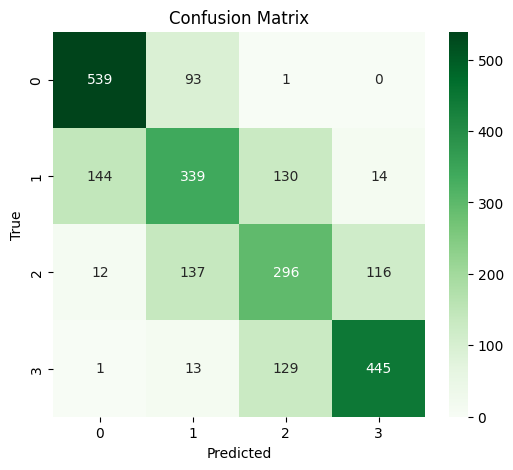

In [59]:
print(classification_report(y_test_cls, y_hat,digits=4))
print('---------------------------------------------------------------------')
plot = confusion_matrix(y_test_cls, y_hat)
plt.figure(figsize=(6,5))
sns.heatmap(plot, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [61]:
import os, mlflow, tempfile, pickle
from pathlib import Path
import sys, os; sys.path.append(os.getcwd())

mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"   
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"

with mlflow.start_run():
    with tempfile.TemporaryDirectory() as tmp:
        tmp_dir = Path(tmp)
        (tmp_dir / "model.pkl").write_bytes(pickle.dumps(final_model))

        mlflow.pyfunc.log_model(
            artifact_path="model",                    
            python_model=LogisticRegressionWrapper(),
            artifacts={"model_dir": str(tmp_dir)},
            registered_model_name="st126130-a3-model", )

2025/10/04 19:29:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\lenovo\AppData\Local\Temp\tmprgeo11de\model, flavor: python_function). Fall back to return ['cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/10/04 19:29:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/04 19:29:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'st126130-a3-model' already exists. Creating a new version of this model...
2025/10/04 19:30:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126130-a3-model, version 6
Created version '6' of model 'st126130-a3-model'.


In [62]:
from mlflow.tracking import MlflowClient
c = MlflowClient()
v_latest = max(c.search_model_versions("name='st126130-a3-model'"),
               key=lambda x: int(x.version))
c.transition_model_version_stage("st126130-a3-model", v_latest.version,
                                 stage="Staging", archive_existing_versions=True)
print("Staging -> version", v_latest.version)

Staging -> version 6


In [63]:
model_name_new = "st126130-a3-model"
stage = "Staging"
model_new = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name_new}/{stage}")